In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path
#import tqdm as tqdm
import tqdm.notebook as tqdm
import multiprocessing

Welcome to JupyROOT 6.22/02


In [2]:
N_cpu=multiprocessing.cpu_count()
N_Threads = "%d" % (N_cpu-2)

In [3]:
def make_histo(Data_array,Title,nbins,xmin,xmax,save=True):
    Histo = ROOT.TH1F(Title,Title,nbins,xmin,xmax)
    for value in Data_array:
        Histo.Fill(value)

    Canv=ROOT.TCanvas()
    Histo.Draw()
    
    if save:
        Image_name=Title + '_Histo.pdf'
        Canv.Print(Image_name)
    
    return Histo, Canv

In [4]:
ROOT.gStyle.SetPalette(107)

# THR analysis
* Noise vs VCASN
* Rate vs VCASN
* Area vs PCA ratio 2D Histo

In [5]:
#Run packet analyzer script for all threshold
Data_folder_path="Data"

Run_Analysis = True
Force_Analysis = False

files=os.listdir(Data_folder_path + "/")

with tqdm.tqdm(total=len(files)) as pbar:
    for name in files:
        pbar.update(1)
        if name.startswith('Data_VCASN_'):
            root_file=Path("Analyzed_Data/"+name+"/"+name+".root")
            root_file_existence_flag=root_file.is_file()
            if (Run_Analysis and not root_file_existence_flag) or Force_Analysis:
                args = "-f "+name+" -Df "+Data_folder_path+" -d 1 10 "
                %run 'Packet_analyzer.py' {args}
            

In [6]:
#Noise and rate dependance on VCASN

Area_thr  = 12
Ratio_thr = 4

VCASN_val    = []
Noise_points = []
N_counts     = []
Rate_val     = []
Counts       = []
Time_acq     = []
Strobe_par   = []
Mean_area    = []
Area_err     = []
Mean_PCAr    = []
PCAr_err     = []
Area_arr     = []
PCAr_arr     = []


files=os.listdir(Data_folder_path+"/")
for name in files:
    if name.startswith('Data_VCASN_'):
        V_CASN_THR=int(name.split('_')[2], base=16)
        VCASN_val = np.append(VCASN_val,V_CASN_THR)
        
        file=open("Data/"+name+"/Stat_"+name+".txt")
        line=file.readlines()
        for l in line:
            if (l.startswith("Readout_time")):
                time=float(l.split('=')[1].strip()[:-1])
            if (l.startswith("Strobe")):
                Strobe=int(l.split('=')[1].strip()[:-1])
            if (l.startswith("Gap")):
                Gap=int(l.split('=')[1].strip()[:-1])
        
        filename="Analyzed_Data/"+name+"/"+name+".root"
        root_file_1  = ROOT.TFile.Open(filename)
        Data_tree    = root_file_1.Get("tree")
        Noise        = Data_tree.AsMatrix(['Rnoise'])
        Areas        = Data_tree.AsMatrix(['Rareas'])
        Ratios       = Data_tree.AsMatrix(['Rratios'])
        
        mask_thr   = np.logical_and (np.squeeze(Areas)      > Area_thr, np.squeeze(Ratios)     < Ratio_thr)
        
        Rate_val   = np.append(Rate_val  , len(Areas [mask_thr])*(Strobe+Gap)/(time*Strobe))
        Counts     = np.append(Counts    , len(Areas [mask_thr]))
        Time_acq   = np.append(Time_acq  , time)
        Strobe_par = np.append(Strobe_par, Strobe/(Strobe+Gap))
        Mean_area  = np.append(Mean_area , np.mean(Areas [mask_thr]))
        Area_err   = np.append(Area_err  , np.std(Areas [mask_thr]))
        Mean_PCAr  = np.append(Mean_PCAr , np.mean(Ratios [mask_thr]))
        PCAr_err   = np.append(PCAr_err  , np.std(Ratios [mask_thr]))
           
        Area_arr.append(Areas[mask_thr])
        PCAr_arr.append(Ratios[mask_thr])
        
        N_counts     = np.append(N_counts,(Noise[0]+len(Areas[np.invert(mask_thr)])))
        Noise_points = np.append(Noise_points,(Noise[0]+len(Areas[np.invert(mask_thr)]))*(Strobe+Gap)/(time*Strobe))
        

In [7]:
np.array(Area_arr[0])


array([[32.],
       [28.],
       [34.],
       ...,
       [20.],
       [32.],
       [32.]])

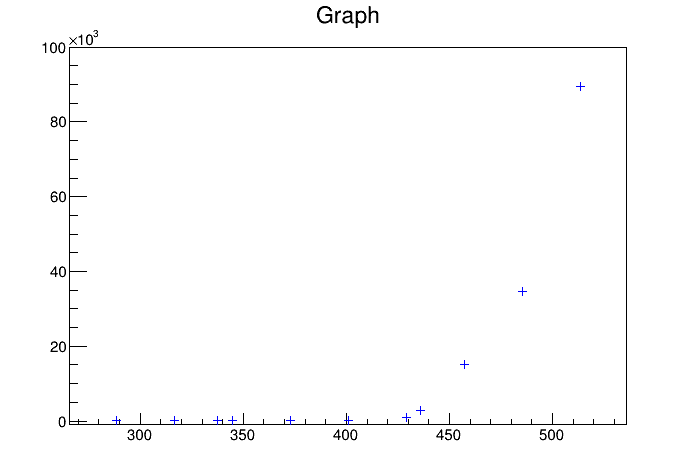

In [8]:
#plt.plot(VCASN_val,Noise_points, 'bo')

DAC_unit=1.8/256*1000

VCASN_err=np.ones(len(Noise_points))*(1/np.sqrt(12))*DAC_unit

Noise_graph = ROOT.TGraph(len(Noise_points),VCASN_val*DAC_unit,Noise_points)
Exp_func    = ROOT.TF1('Exp_func','[0]*exp((x-[1])/[2])+[3]')
Pol4        = ROOT.TF1('Pol4','pol4')

Noise_graph.SetMarkerColor(4)
Noise_graph.SetMarkerStyle(2)
Noise_graph.SetMarkerSize(1)
YAxis = Noise_graph.GetYaxis()
YAxis.SetRangeUser(-1000,100000)

Exp_func.SetParameters(0.007,22,3,-500)

#Noise_graph.Fit('Exp_func')

NPC = ROOT.TCanvas()

Noise_graph.Draw('AP')
NPC.Draw()

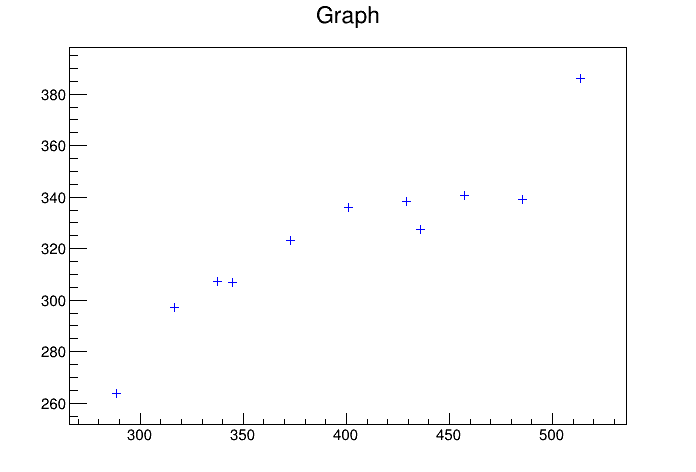

In [9]:
#plt.plot(VCASN_val,Noise_points, 'bo')
Rate_graph  = ROOT.TGraph(len(Rate_val),VCASN_val*DAC_unit,Rate_val)
#xp_func    = ROOT.TF1('Exp_func','[0]*exp(x/[1])+[2]')
#Pol4        = ROOT.TF1('Pol4','pol4')

Rate_graph.SetMarkerColor(4)
Rate_graph.SetMarkerStyle(2)
Rate_graph.SetMarkerSize(1)

#Exp_func.SetParameters(5,8,0.1)

#Rate_graph.Fit('Exp_func')

RC = ROOT.TCanvas()

Rate_graph.Draw('AP')
RC.Draw()

Info in <TCanvas::Print>: pdf file Graph_images/SNR_graph.pdf has been created


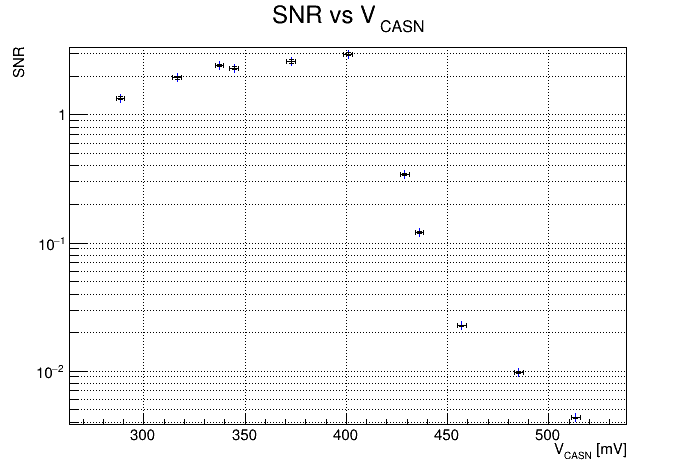

In [10]:
#plt.plot(VCASN_val,Noise_points, 'bo')
SNR       = Rate_val/Noise_points
Rate_err  = np.sqrt(Counts)/(Time_acq*Strobe_par)
Noise_err = np.sqrt(N_counts)/(Time_acq*Strobe_par)
SNR_err   = np.sqrt((Rate_err/(Noise_points))**2+(Noise_err*(Rate_val)/(Noise_points**2))**2)

SNR_graph  = ROOT.TGraphErrors(len(Rate_val),VCASN_val*DAC_unit,Rate_val/Noise_points,VCASN_err,SNR_err)
#xp_func    = ROOT.TF1('Exp_func','[0]*exp(x/[1])+[2]')
#Pol4        = ROOT.TF1('Pol4','pol4')

SNR_graph.SetMarkerColor(4)
SNR_graph.SetMarkerStyle(2)
SNR_graph.SetMarkerSize(1)

YAxis = SNR_graph.GetYaxis()
XAxis = SNR_graph.GetXaxis()
YAxis.SetTitle('SNR')
XAxis.SetTitle('V_{CASN} [mV]')

SNR_graph.SetTitle('SNR vs V_{CASN}')


#Exp_func.SetParameters(5,8,0.1)

#Rate_graph.Fit('Exp_func')

SNRC = ROOT.TCanvas()

SNRC.SetLogy()
SNRC.SetGrid()

SNR_graph.Draw('AP')
SNRC.Draw()
SNRC.Print('Graph_images/SNR_graph.pdf')

Info in <TCanvas::Print>: pdf file Graph_images/Area_graph.pdf has been created


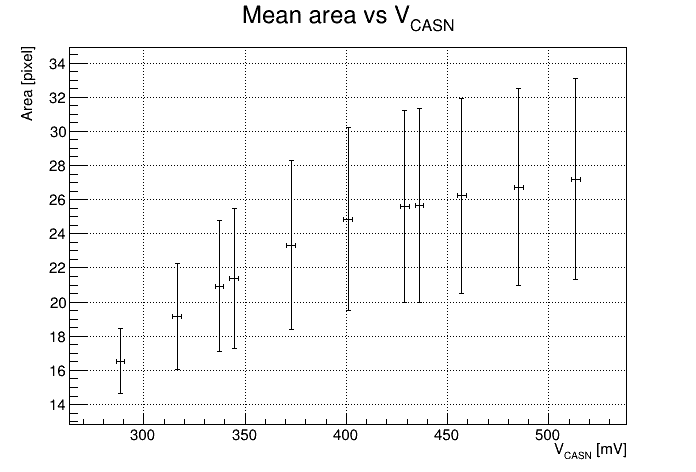

In [11]:
#plt.plot(VCASN_val,Noise_points, 'bo')

Area_graph  = ROOT.TGraphErrors(len(Mean_area),VCASN_val*DAC_unit,Mean_area,VCASN_err,Area_err)


Area_graph.SetMarkerColor(4)
Area_graph.SetMarkerStyle(2)
Area_graph.SetMarkerSize(1)

YAxis = Area_graph.GetYaxis()
XAxis = Area_graph.GetXaxis()
YAxis.SetTitle('Area [pixel]')
XAxis.SetTitle('V_{CASN} [mV]')

Area_graph.SetTitle('Mean area vs V_{CASN}')

#Exp_func.SetParameters(5,8,0.1)

#Rate_graph.Fit('Exp_func')

AC = ROOT.TCanvas()

AC.SetGrid()

Area_graph.Draw('AP')
AC.Draw()
AC.Print('Graph_images/Area_graph.pdf')

Info in <TCanvas::Print>: pdf file Graph_images/PCA_graph.pdf has been created


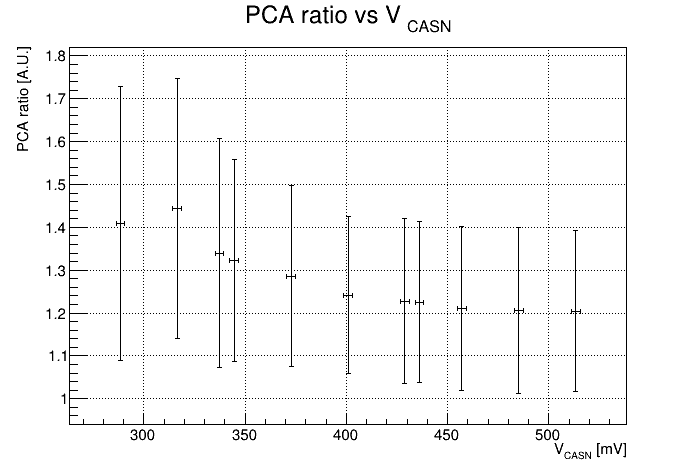

In [12]:
#plt.plot(VCASN_val,Noise_points, 'bo')

PCA_graph  = ROOT.TGraphErrors(len(Mean_PCAr),VCASN_val*DAC_unit,Mean_PCAr,VCASN_err,PCAr_err)


PCA_graph.SetMarkerColor(4)
PCA_graph.SetMarkerStyle(2)
PCA_graph.SetMarkerSize(1)

YAxis = PCA_graph.GetYaxis()
XAxis = PCA_graph.GetXaxis()
YAxis.SetTitle('PCA ratio [A.U.]')
XAxis.SetTitle('V_{CASN} [mV]')

PCA_graph.SetTitle('PCA ratio vs V_{CASN}')

#Exp_func.SetParameters(5,8,0.1)

#Rate_graph.Fit('Exp_func')

PCAC = ROOT.TCanvas()

PCAC.SetGrid()

PCA_graph.Draw('AP')
PCAC.Draw()
PCAC.Print('Graph_images/PCA_graph.pdf')

In [13]:
#convert the TTree in np arrays
name        = "bkg_24h_151220"
filename    = "Analyzed_Data/"+name+"/"+name+".root"
root_file = ROOT.TFile.Open(filename)
Data_tree   = root_file.Get("tree")

Areas_AxP  = Data_tree.AsMatrix(['Rareas'])
Means_AxP  = Data_tree.AsMatrix(['Rmeanx','Rmeany'])
Ratios_AxP = Data_tree.AsMatrix(['Rratios'])

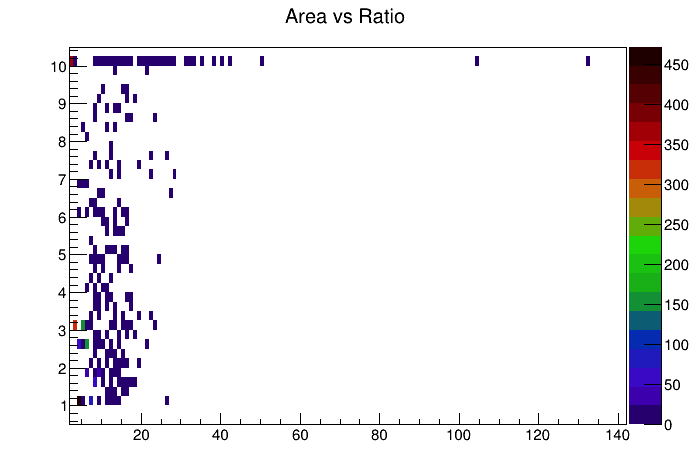

In [14]:
ar_max=int(np.amax(Areas_AxP))
A_R_Histo = ROOT.TH2D('A_R_Histo','Area vs Ratio',ar_max-2,2,ar_max,40,0.5,10.5)

for i in range(len(Areas_AxP)):
    A_R_Histo.Fill(Areas_AxP[i],Ratios_AxP[i])
    
    
ARC=ROOT.TCanvas()
A_R_Histo.Draw("COLZ")
A_R_Histo.SetStats(False)
ARC.Draw()

# X-rays

In [15]:
run_analysis = False

if run_analysis:
    Args = "-Df Data -f bkg_X_90m_181220 -p -A DB -NThr 3 -d 3 15 -s 17"
    %run 'Packet_analyzer.py' {Args}

In [16]:
#convert the TTree in np arrays
name        = "bkg_X_90m_181220"
filename    = "Analyzed_Data/"+name+"/"+name+".root"
root_file   = ROOT.TFile.Open(filename)
Data_tree   = root_file.Get("tree")

file=open("Data/"+name+"/Stat_"+name+".txt")
line=file.readlines()
for l in line:
    if (l.startswith("Readout_time")):
        time=float(l.split('=')[1].strip()[:-1])
    if (l.startswith("Strobe")):
        Strobe=int(l.split('=')[1].strip()[:-1])
    if (l.startswith("Gap")):
        Gap=int(l.split('=')[1].strip()[:-1])

Areas_X  = Data_tree.AsMatrix(['Rareas'])
Means_X  = Data_tree.AsMatrix(['Rmeanx','Rmeany'])
Ratios_X = Data_tree.AsMatrix(['Rratios'])

Time_X   = (time*Strobe)/(Strobe+Gap)

Info in <TCanvas::Print>: pdf file Area_Histo.pdf has been created


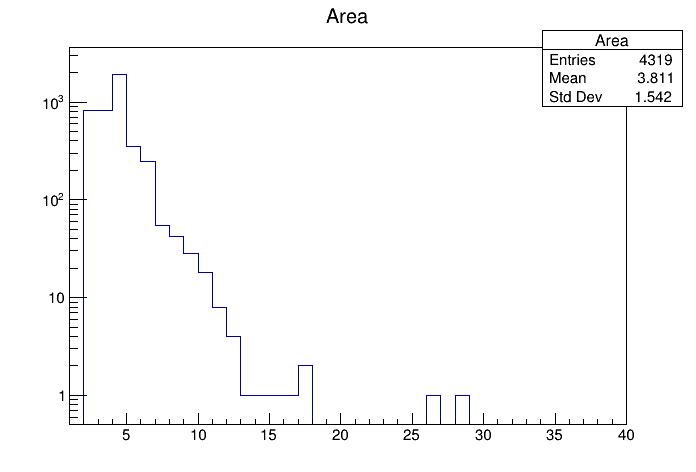

In [17]:
ar_max=int(np.amax(Areas_X))
nbins=int((ar_max-1))
ArXHist,AXC=make_histo(Areas_X,'Area',nbins,1,ar_max)
AXC.SetLogy()
AXC.Draw()

In [18]:
print('Areas     = %f +- %f' % (np.mean(Areas_X) , np.std(Areas_X)) )
print('PCA ratio = %f +- %f' % (np.mean(Ratios_X), np.std(Ratios_X)))
print('Rate      = %f'       % (len(Areas_X)/Time_X*3600)           )

Areas     = 3.819171 +- 1.637414
PCA ratio = 3.418758 +- 3.312493
Rate      = 28793.330683


# Cosimc rays

In [19]:
run_analysis = False

if run_analysis:
    Args = "-Df Data -f bkg_24h_151220 -p -A DB -NThr 3 -d 3 15 -s 17"
    %run 'Packet_analyzer.py' {Args}

In [20]:
#convert the TTree in np arrays
name        = "bkg_24h_151220"
filename    = "Analyzed_Data/"+name+"/"+name+".root"
root_file   = ROOT.TFile.Open(filename)
Data_tree   = root_file.Get("tree")

file=open("Data/"+name+"/Stat_"+name+".txt")
line=file.readlines()
for l in line:
    if (l.startswith("Readout_time")):
        time=float(l.split('=')[1].strip()[:-1])
    if (l.startswith("Strobe")):
        Strobe=int(l.split('=')[1].strip()[:-1])
    if (l.startswith("Gap")):
        Gap=int(l.split('=')[1].strip()[:-1])

Areas_C  = Data_tree.AsMatrix(['Rareas'])
Means_C  = Data_tree.AsMatrix(['Rmeanx','Rmeany'])
Ratios_C = Data_tree.AsMatrix(['Rratios'])

Time_C   = (time*Strobe)/(Strobe+Gap)

Info in <TCanvas::Print>: pdf file Area_Histo.pdf has been created


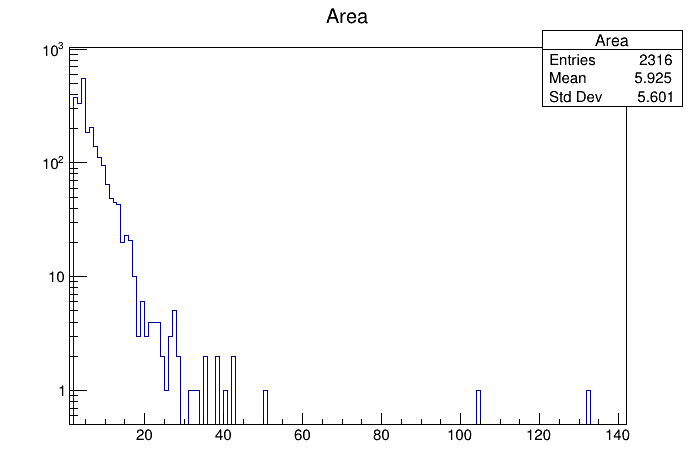

In [21]:
ar_max=int(np.amax(Areas_C))
nbins=int((ar_max-1))
ArCHist,ACC=make_histo(Areas_C,'Area',nbins,1,ar_max)
ACC.SetLogy()
ACC.Draw()

In [22]:
print('Areas     = %f +- %f' % (np.mean(Areas_C) , np.std(Areas_C)) )
print('PCA ratio = %f +- %f' % (np.mean(Ratios_C), np.std(Ratios_C)))
print('Rate      = %f'       % (len(Areas_C)/Time_C*3600)           )

Areas     = 5.983592 +- 6.273191
PCA ratio = 3.933800 +- 3.317195
Rate      = 578.999988


# ALPHA

In [23]:
Time_A = 0

Data_folder    ="Data"

Run_Analysis   = True
Force_Analysis = False

#load files of a cartain dataset
files=os.listdir(Data_folder + "/")

with tqdm.tqdm(total=len(files)) as pbar:
    for name in files:
        pbar.update(1)
        if name.startswith("center_alpide_17"):
            
            file=open(Data_folder+"/"+name+"/Stat_"+name+".txt")
            line=file.readlines()
            for l in line:
                if (l.startswith("Readout_time")):
                    time=float(l.split('=')[1].strip()[:-1])
                if (l.startswith("Strobe")):
                    Strobe=int(l.split('=')[1].strip()[:-1])
                if (l.startswith("Gap")):
                    Gap=int(l.split('=')[1].strip()[:-1])

            exp_time = (Strobe*time)/(Gap+Strobe)
            Time_A  += exp_time
            
            root_file=Path("Analyzed_Data/"+name+"/"+name+".root")
            root_file_existence_flag=root_file.is_file()
            if (Run_Analysis and not root_file_existence_flag) or Force_Analysis:
                Args = "-Df "+Data_folder+" -f "+name+" -p -A DB -NThr "+N_Threads+" -d 3 15 -s 17"
                %run 'Packet_analyzer.py' {Args}
                #%run 'Packet_analyzer-Copy2.py' {Args}
            

In [24]:
! $ROOTSYS/bin/hadd -f Tot_data_tree/Tot_alpha_par.root Analyzed_Data/center_alpide_17*/*.root 

hadd Target file: Tot_data_tree/Tot_alpha_par.root
hadd compression setting for all output: 1
hadd Source file 1: Analyzed_Data/center_alpide_17_DC_5m_run10_170121/center_alpide_17_DC_5m_run10_170121.root
hadd Source file 2: Analyzed_Data/center_alpide_17_DC_5m_run11_170121/center_alpide_17_DC_5m_run11_170121.root
hadd Source file 3: Analyzed_Data/center_alpide_17_DC_5m_run1_170121/center_alpide_17_DC_5m_run1_170121.root
hadd Source file 4: Analyzed_Data/center_alpide_17_DC_5m_run12_170121/center_alpide_17_DC_5m_run12_170121.root
hadd Source file 5: Analyzed_Data/center_alpide_17_DC_5m_run13_170121/center_alpide_17_DC_5m_run13_170121.root
hadd Source file 6: Analyzed_Data/center_alpide_17_DC_5m_run14_170121/center_alpide_17_DC_5m_run14_170121.root
hadd Source file 7: Analyzed_Data/center_alpide_17_DC_5m_run15_170121/center_alpide_17_DC_5m_run15_170121.root
hadd Source file 8: Analyzed_Data/center_alpide_17_DC_5m_run16_170121/center_alpide_17_DC_5m_run16_170121.root
hadd Source file 9: 

In [25]:
root_file  =ROOT.TFile.Open("Tot_data_tree/Tot_alpha_par.root")
Data_tree  = root_file.Get("tree")

Areas_A   = Data_tree.AsMatrix(['Rareas'])
Means_A   = Data_tree.AsMatrix(['Rmeanx','Rmeany'])
Ratios_A  = Data_tree.AsMatrix(['Rratios'])

In [26]:
Area_thr  = 12
Ratio_thr = 3.5

mask_thr  =  np.logical_and (np.squeeze(Areas_A)      > Area_thr, np.squeeze(Ratios_A)     < Ratio_thr)


Areas_disc_A  = Areas_A [mask_thr]
Ratios_disc_A = Ratios_A[mask_thr]

Info in <TCanvas::Print>: pdf file Area_Histo.pdf has been created


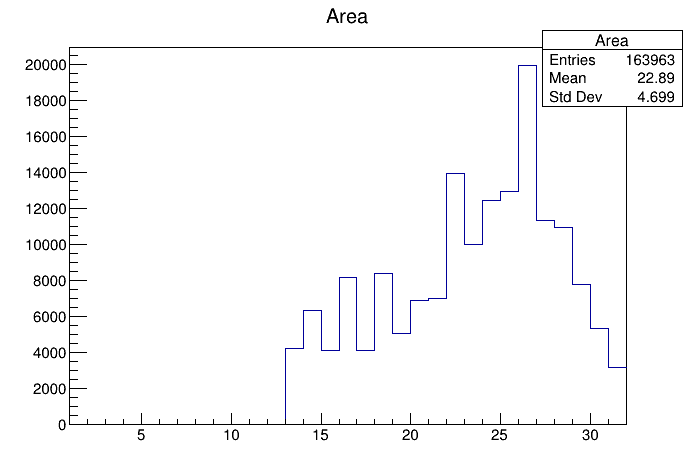

In [27]:
ar_max = int(np.amax(Areas_disc_A))
nbins  = int((ar_max-1))

ArAHist,AAC = make_histo(Areas_disc_A,'Area',nbins,1,ar_max)
#AAC.SetLogy()
AAC.Draw()

In [83]:
print('Areas     = %f +- %f' % (np.mean(Areas_disc_A) , np.std(Areas_disc_A)) )
print('PCA ratio = %f +- %f' % (np.mean(Ratios_disc_A), np.std(Ratios_disc_A)))
print('Rate      = %f'       % (len(Areas_disc_A)/Time_A*3600))
print('\n')
print('Non discriminated values')
print('Areas     = %f +- %f' % (np.mean(Areas_A) , np.std(Areas_A)) )
print('PCA ratio = %f +- %f' % (np.mean(Ratios_A), np.std(Ratios_A)))
print('Rate      = %f'       % (len(Areas_A)/Time_A*3600)           )

Areas     = 22.992657 +- 4.767127
PCA ratio = 1.291479 +- 0.201600
Rate      = 1147736.315801


Non discriminated values
Areas     = 19.465633 +- 8.016163
PCA ratio = 1.550925 +- 1.216547
Rate      = 1467964.008872


# Various plots

In [29]:
import pandas as pd
import bokeh.palettes as palette

In [30]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

In [65]:
#col      = palette.brewer['RdYlGn'][10]
col = palette.Category20[10]

In [66]:
d = {
    "DAC_unit"      : DAC_unit,
    "VCASN_val"     : VCASN_val,
    "Rate_val"      : Rate_val,
    "Noise_points"  : Noise_points,
    "SNR"           : SNR,
    "SNR_err"       : SNR_err,
    "VCASN_err"     : VCASN_err,
    "Mean_area"     : Mean_area,
    "Area_err"      : Area_err,
    "Mean_PCAr"     : Mean_PCAr,
    "PCAr_err"      : PCAr_err
}

df = pd.DataFrame(data=d)
df = df.sort_values(by=['VCASN_val'])

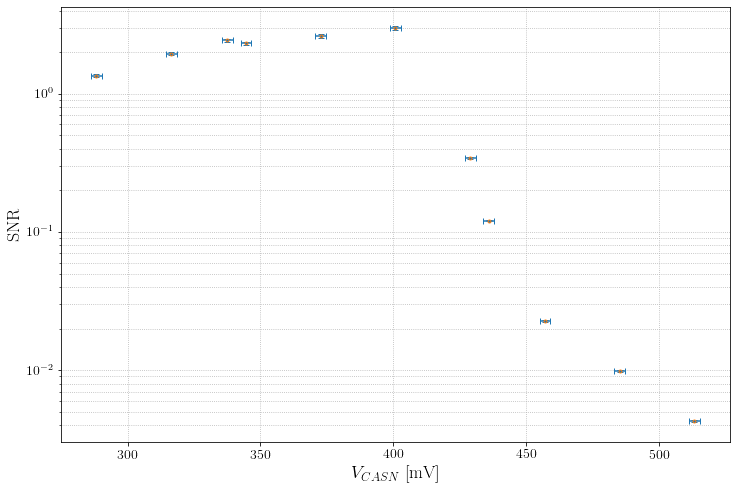

In [90]:
plt.figure(figsize=(12,8))
plt.yscale("log")
plt.errorbar(df["VCASN_val"]*df["DAC_unit"],
             df["SNR"],
             xerr            = df["VCASN_err"],
             yerr            = df["SNR_err"],
             fmt             = 'o',
             markerfacecolor = col[0],
             color           = col[2],
             ecolor          = col[0],
             label           = "data",
             alpha           = 1,
             markersize      = 3,
             capsize         = 3
             ) #fillstyle="none"
plt.xlabel("$V_{\mathrm{CASN}}$ [mV]")
plt.ylabel("SNR")

plt.grid(True, linestyle=':', which='both')
#plt.legend()
plt.savefig("Graph_images/SNR_graph_py", dpi=200)
plt.show()

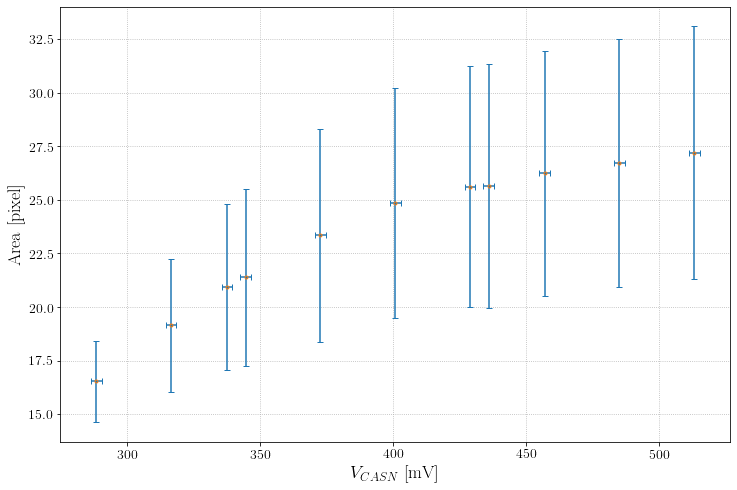

In [91]:
plt.figure(figsize=(12,8))
#plt.yscale("log")
plt.errorbar(df["VCASN_val"]*df["DAC_unit"],
             df["Mean_area"],
             xerr            = df["VCASN_err"],
             yerr            = df["Area_err"],
             fmt             = 'o',
             markerfacecolor = col[0],
             color           = col[2],
             ecolor          = col[0],
             label           = "data",
             alpha           = 1,
             markersize      = 3,
             capsize         = 3) #fillstyle="none"
plt.xlabel("$V_{\mathrm{CASN}}$ [mV]")
plt.ylabel("Area [pixel]")


plt.grid(True, linestyle=':')
#plt.legend()
plt.savefig('Graph_images/Area_graph_py', dpi=200)
plt.show()


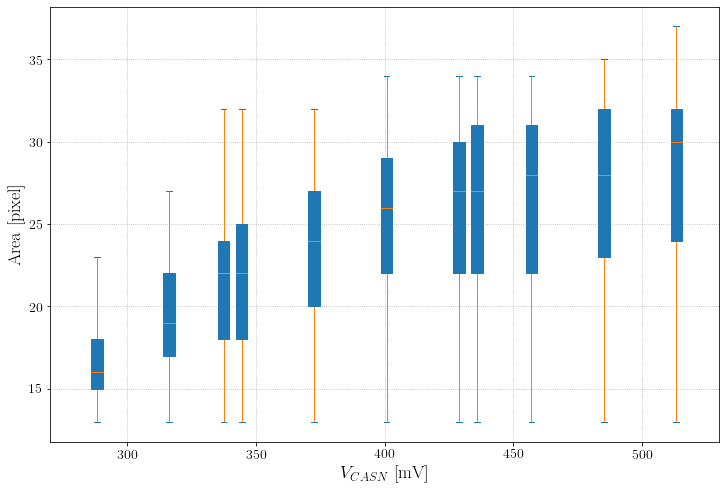

In [92]:
plt.figure(figsize=(12,8))

for i in range(len(VCASN_val)):
    bp = plt.boxplot(Area_arr[i],
                patch_artist=True,
                sym       = '',
                positions = [VCASN_val[i]*DAC_unit],
                widths    = [4.5],
                whis      = 3
               )
    
    plt.setp(bp['boxes']   , color=col[0])
    plt.setp(bp['whiskers'], color=col[2])
    plt.setp(bp['caps']    , color=col[0])

plt.xticks(range(250,600,50), labels=range(250,600,50))
plt.xlim([270,530])

plt.xlabel("$V_{\mathrm{CASN}}$ [mV]")
plt.ylabel("Area [pixel]")

plt.grid(True, linestyle=':')
plt.savefig('Graph_images/Areagraph_py_box', dpi=200)
plt.show()

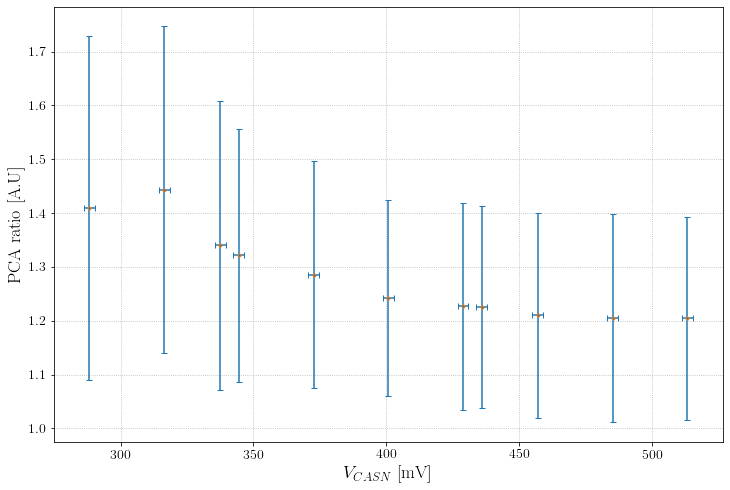

In [93]:
plt.figure(figsize=(12,8))
#plt.yscale("log")
plt.errorbar(df["VCASN_val"]*df["DAC_unit"],
             df["Mean_PCAr"],
             xerr            = df["VCASN_err"],
             yerr            = df["PCAr_err"],
             fmt             = 'o',
             markerfacecolor = col[0],
             color           = col[2],
             ecolor          = col[0],
             label           = "data",
             alpha           = 1,
             markersize      = 3,
             capsize         = 3) #fillstyle="none"
plt.xlabel("$V_{\mathrm{CASN}}$ [mV]")
plt.ylabel("PCA ratio [A.U]")

plt.grid(True, linestyle=':')
#plt.legend()
plt.savefig('Graph_images/PCArgraph_py', dpi=200)
plt.show()


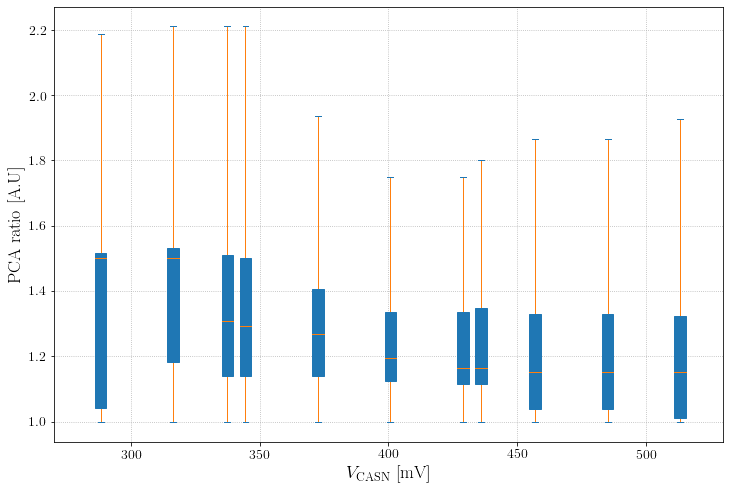

In [106]:
plt.figure(figsize=(12,8))

for i in range(len(VCASN_val)):
    bp = plt.boxplot(PCAr_arr[i],
                patch_artist=True,
                sym       = '',
                positions = [VCASN_val[i]*DAC_unit],
                widths    = [4.5],
                whis      = 2
               )
    
    plt.setp(bp['boxes']   , color=col[0])
    plt.setp(bp['whiskers'], color=col[2])
    plt.setp(bp['caps']    , color=col[0])
    plt.setp(bp['medians'] , color=col[2])

plt.xticks(range(250,600,50), labels=range(250,600,50))
plt.xlim([270,530])

plt.xlabel("$V_{\mathrm{CASN}}$ [mV]")
plt.ylabel("PCA ratio [A.U]")

plt.grid(True, linestyle=':')
plt.savefig('Graph_images/PCArgraph_py_box', dpi=200)
plt.show()

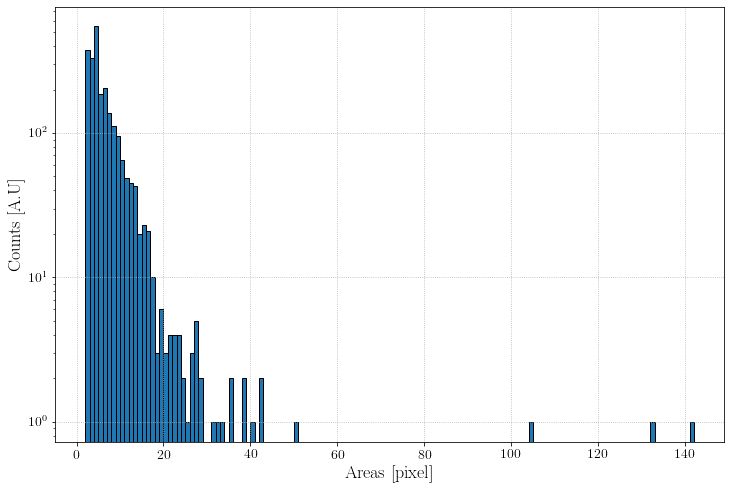

In [87]:
plt.figure(figsize=(12,8))
plt.yscale("log")
plt.hist(Areas_C,
         bins      = int(max(Areas_C)-min(Areas_C)),
         edgecolor = 'black',
         color     = col[0]
        ) #fillstyle="none"
plt.xlabel("Areas [pixel]")
plt.ylabel("Counts [A.U]")

plt.grid(True, linestyle=':')
#plt.legend()
plt.savefig('Graph_images/Cosmic_hist_py', dpi=200)
plt.show()


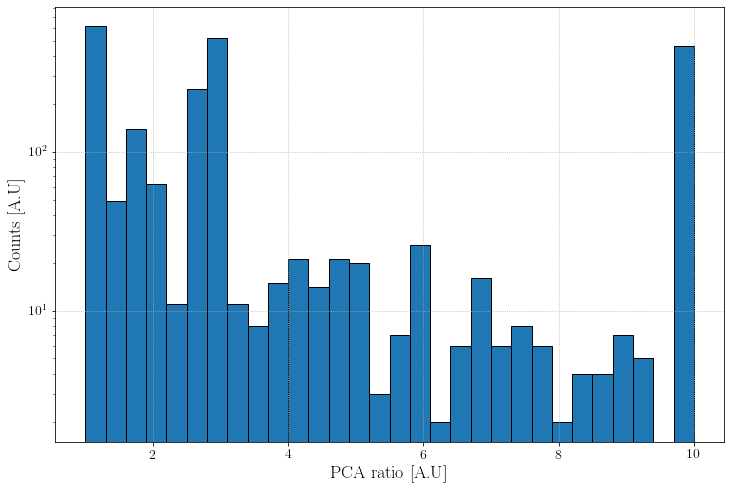

In [88]:
plt.figure(figsize=(12,8))
plt.yscale("log")
plt.hist(Ratios_C,
         bins      = 30,
         edgecolor = 'black',
         color     = col[0]
        ) #fillstyle="none"
plt.xlabel("PCA ratio [A.U]")
plt.ylabel("Counts [A.U]")

plt.grid(True, linestyle=':')
#plt.legend()
plt.savefig('Graph_images/Cosmic_PCA_hist_py', dpi=200)
plt.show()


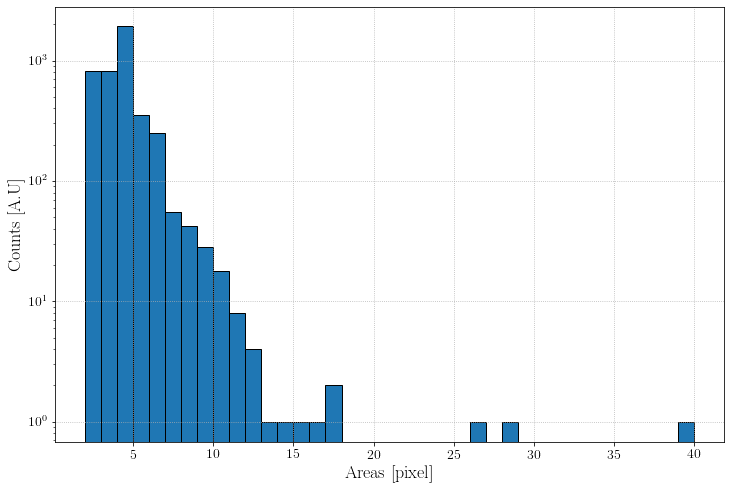

In [107]:
plt.figure(figsize=(12,8))
plt.yscale("log")
plt.hist(Areas_X,
         bins      = int(max(Areas_X)-min(Areas_X)),
         edgecolor = 'black',
         color     = col[0]
        ) #fillstyle="none"
plt.xlabel("Areas [pixel]")
plt.ylabel("Counts [A.U]")

plt.grid(True, linestyle=':')
#plt.legend()
plt.savefig('Graph_images/X_hist_py', dpi=200)
plt.show()

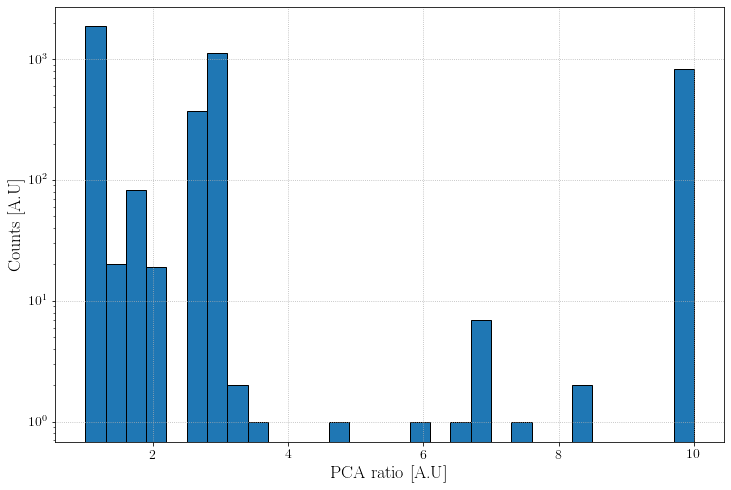

In [108]:
plt.figure(figsize=(12,8))
plt.yscale("log")
plt.hist(Ratios_X,
         bins  = 30,
         edgecolor = 'black',
         color     = col[0]
        ) #fillstyle="none"
plt.xlabel("PCA ratio [A.U]")
plt.ylabel("Counts [A.U]")

plt.grid(True, linestyle=':')
#plt.legend()
plt.savefig('Graph_images/X_PCA_hist_py', dpi=200)
plt.show()

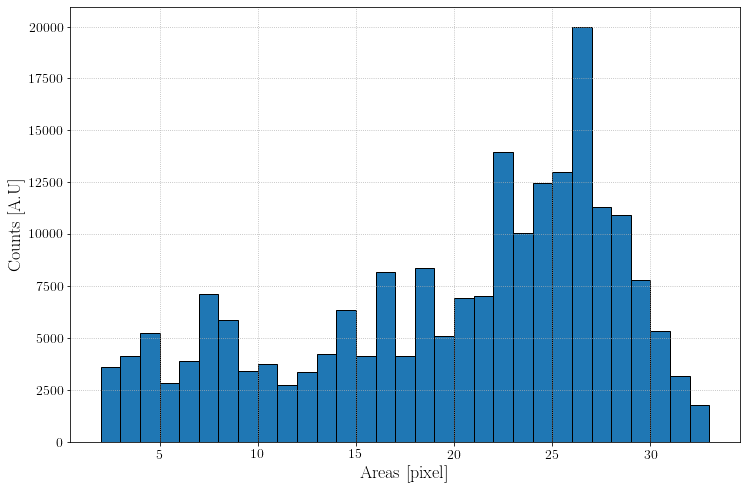

In [109]:
plt.figure(figsize=(12,8))
#plt.yscale("log")
plt.hist(Areas_A,
         bins=int(max(Areas_A)-min(Areas_A)),
         edgecolor = 'black',
         color     = col[0]
        ) #fillstyle="none"
plt.xlabel("Areas [pixel]")
plt.ylabel("Counts [A.U]")

plt.grid(True, linestyle=':')
#plt.legend()
plt.savefig('Graph_images/Alpha_hist_py', dpi=200)
plt.show()

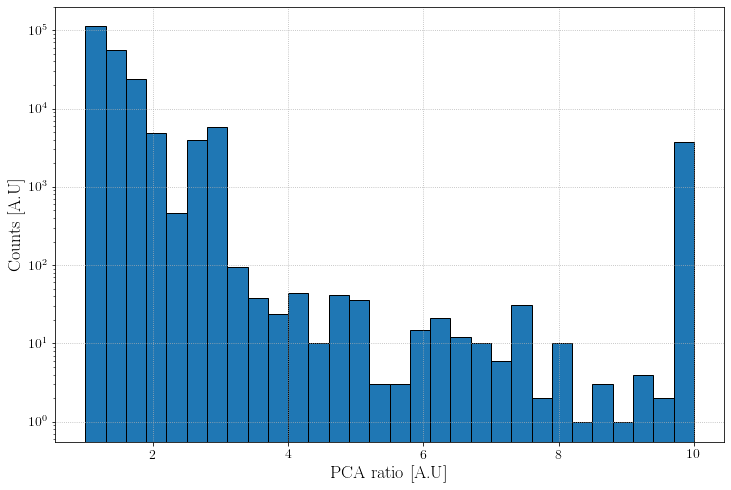

In [110]:
plt.figure(figsize=(12,8))
plt.yscale("log")
plt.hist(Ratios_A,
         bins  = 30,
         edgecolor = 'black',
         color     = col[0]
        ) #fillstyle="none"
plt.xlabel("PCA ratio [A.U]")
plt.ylabel("Counts [A.U]")

plt.grid(True, linestyle=':')
#plt.legend()
plt.savefig('Graph_images/Alpha_PCA_hist_py', dpi=200)
plt.show()

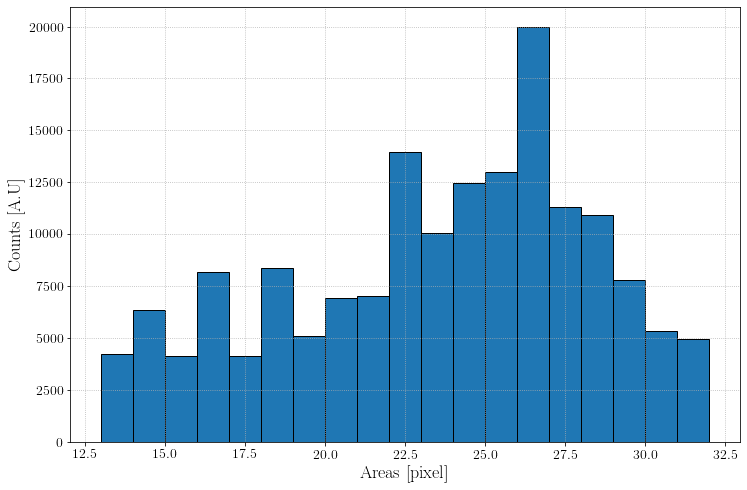

In [111]:
plt.figure(figsize=(12,8))
#plt.yscale("log")
plt.hist(Areas_disc_A,
         bins=int(max(Areas_disc_A)-min(Areas_disc_A)),
         edgecolor = 'black',
         color     = col[0]
        ) #fillstyle="none"
plt.xlabel("Areas [pixel]")
plt.ylabel("Counts [A.U]")

plt.grid(True, linestyle=':')
#plt.legend()
plt.savefig('Graph_images/Alpha_disc_hist_py', dpi=200)
plt.show()

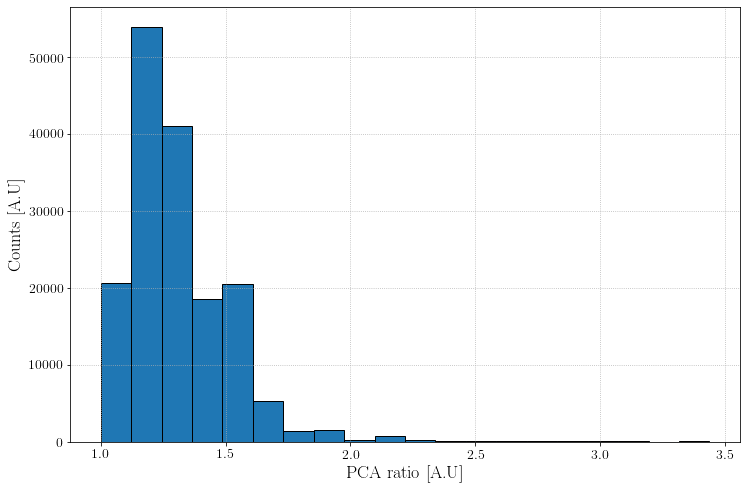

In [112]:
plt.figure(figsize=(12,8))
#plt.yscale("log")
plt.hist(Ratios_disc_A,
         bins  = 20,
         edgecolor = 'black',
         color     = col[0]
        ) #fillstyle="none"
plt.xlabel("PCA ratio [A.U]")
plt.ylabel("Counts [A.U]")

plt.grid(True, linestyle=':')
#plt.legend()
plt.savefig('Graph_images/Alpha_PCA_disc_hist_py', bbox_inches='tight')
#fig.savefig(SAVE_PATH + "picoscope/test_run_amplitudes.pdf", bbox_inches='tight')
plt.show()

In [ ]:
fig = plt.figure(figsize=(6, 4))